<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Model Read

In [1]:
#===============================================
# Basic Imports
BASE_FOLDER = '../../'
%run -i ..\..\utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i ..\..\utility\modeling\JupyterLoad_modeling.py

from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import glob
import seaborn as sns
sns.set()

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe


In [75]:
def read_pipes(name='models_aggregated.pkl'):
    list_of_pipes = glob.glob(BASE_FOLDER + '/modeling/stochastic/pipes/*.pkl', recursive=True)
    columns = ['model_path'
        , 'roc_auc_framed'
        , 'roc_auc_aggr'
        , 'SNR'
        , 'machine'
        , 'ID'
        , 'feature_type'
        , 'feature_params'
        , 'model_type'
        , 'model_params']
    df = pd.DataFrame(columns=columns)

    for i, pipe_path in enumerate(tqdm(list_of_pipes)):
        with open(pipe_path, 'rb') as pipe_file:
            pipe = pickle.load(pipe_file)

            predictions = pipe.df_test.groupby(by='path').sum().pred_scores
            pipe.df_test['ground_truth'] = pipe.ground_truth
            labels = pipe.df_test.groupby(by='path').median().ground_truth
            roc_auc_aggr = roc_auc_score(labels, predictions)

            data=[[
                pipe_path,
                pipe.roc_auc,
                roc_auc_aggr,
                pipe.task['SNR'],
                pipe.task['machine'],
                pipe.task['ID'],
                pipe.task['feat_col'],
                str(pipe.task['feat']),
                pipe.model.name,
                pipe.model_args]]
            df = df.append(pd.DataFrame(data=data, columns=columns))
    
    
    # dataframe postprocessing
    df = df.reset_index()
    df['roc_diff'] = df.roc_auc_aggr - df.roc_auc_framed

    df_tmp = pd.DataFrame([])
    for i, row in df.iterrows():
        for key, value in row.feature_params.items():
            row['feat_'+key] = value
        for key, value in row.model_params.items():
            row['model_'+key] = value
        df_tmp = df_tmp.append(row)

    df = df.join(pd.Series(['sporadic' if machine in ['slider', 'valve'] else 'continuous' for machine in df.machine], name='activation_type', index=df.index))

    return df_tmp


In [2]:
name = 'models_aggregated.dataframe'
if not os.path.exists(name):
    df = read_pipes(name)
    df.to_pickle(name)
else:
    df = pd.read_pickle(name)

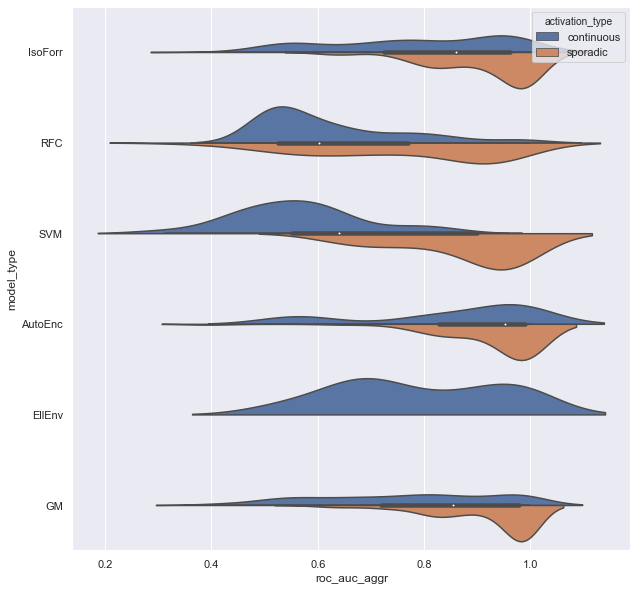

In [7]:
#df.boxplot(column='roc_auc_aggr', by=['model_type', 'activation_type'], figsize=(10,10), vert=False)
plt.figure(figsize=(10,10))
sns.violinplot(data=df, x='roc_auc_aggr', y='model_type', hue='activation_type', split=True)

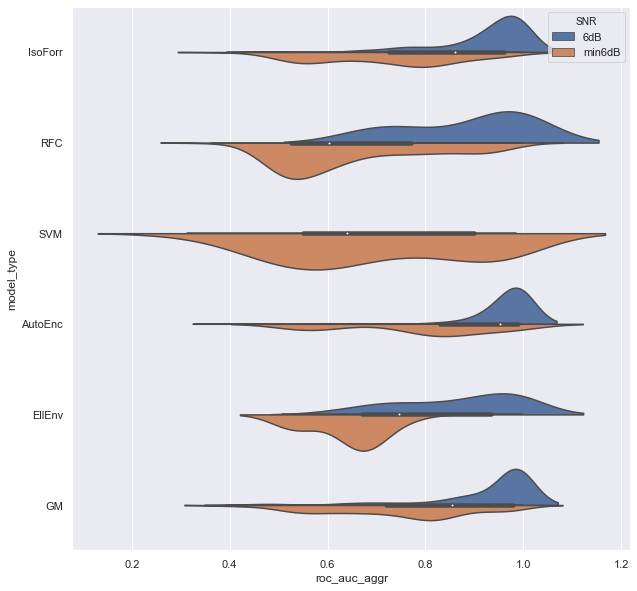

In [286]:
plt.figure(figsize=(10,10))
sns.violinplot(data=df, x='roc_auc_aggr', y='model_type', hue='SNR', split=True)

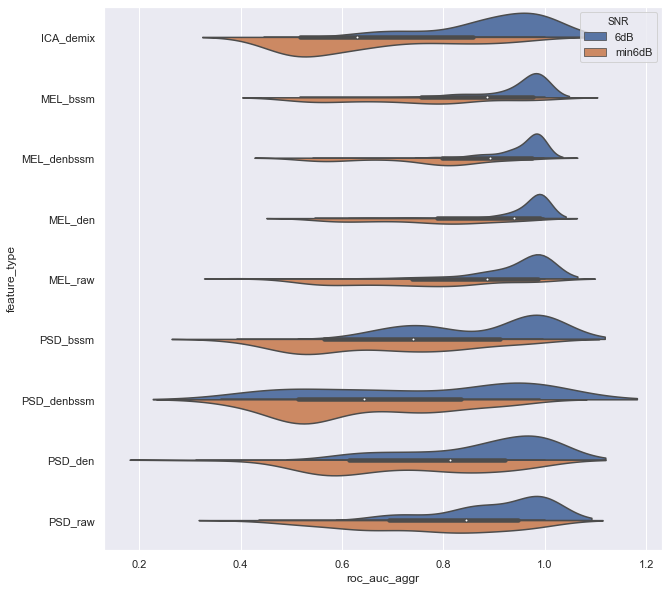

In [290]:
plt.figure(figsize=(10,10))
sns.violinplot(data=df, x='roc_auc_aggr', y='feature_type', hue='SNR', split=True)

In [303]:
df = df.drop(index=df[df.model_epochs==1].index)

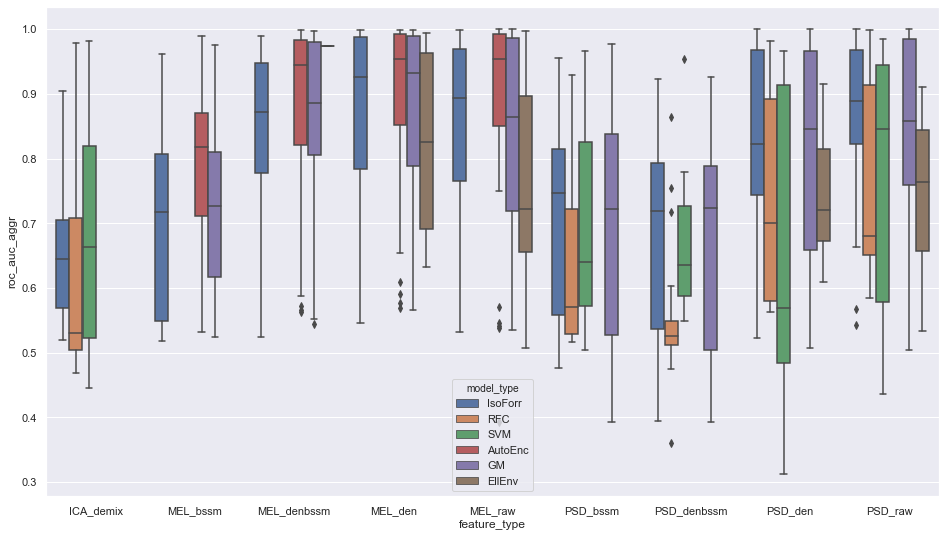

In [305]:
mask = ((df.feature_type == 'PSD_raw') | (df.feature_type == 'PSD_den') | (df.feature_type == 'MEL_raw') | (df.feature_type == 'MEL_denbssm') | (df.feature_type == 'MEL_den') | (df.SNR == 'min6dB'))
plt.figure(figsize=(16,9))
sns.boxplot(data=df[mask], y='roc_auc_aggr', x='feature_type', hue='model_type')

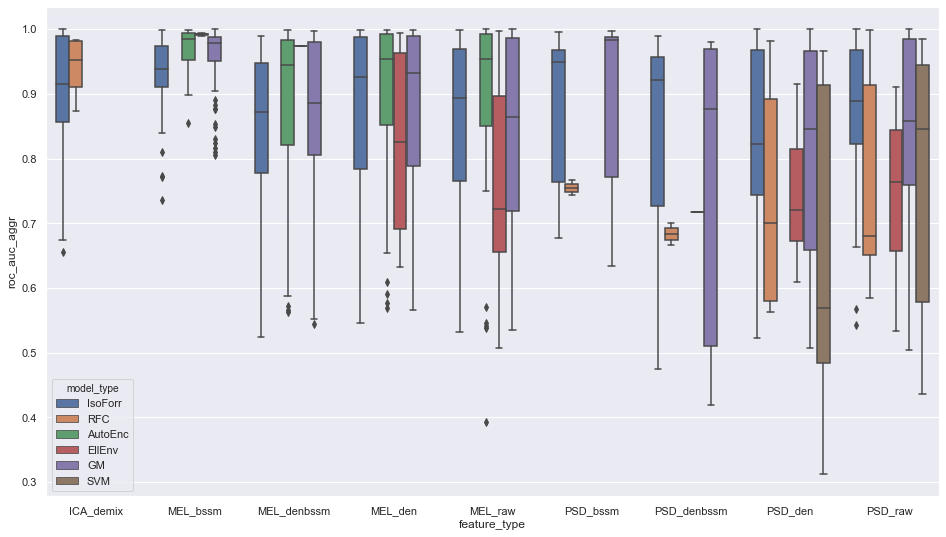

In [306]:
mask = ((df.feature_type == 'PSD_raw') | (df.feature_type == 'PSD_den') | (df.feature_type == 'MEL_raw') | (df.feature_type == 'MEL_denbssm') | (df.feature_type == 'MEL_den') | (df.SNR == '6dB'))
plt.figure(figsize=(16,9))
sns.boxplot(data=df[mask], y='roc_auc_aggr', x='feature_type', hue='model_type')

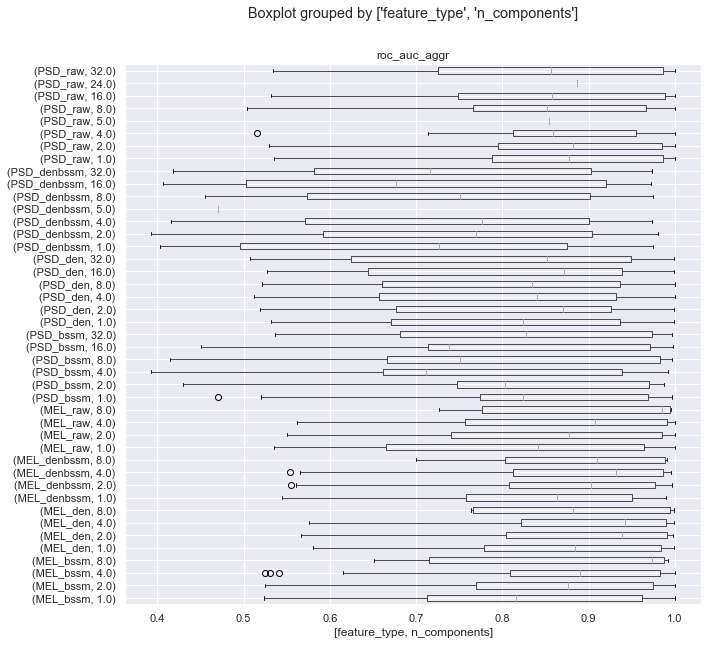

In [158]:
df.join(extract_info(df[df.model_type=='GM'].model_params, 'n_components', 'n_components'))[df.model_type=='GM'].boxplot(column='roc_auc_aggr', by=['feature_type', 'n_components'], figsize=(10,10), vert=False)

<Figure size 720x720 with 0 Axes>

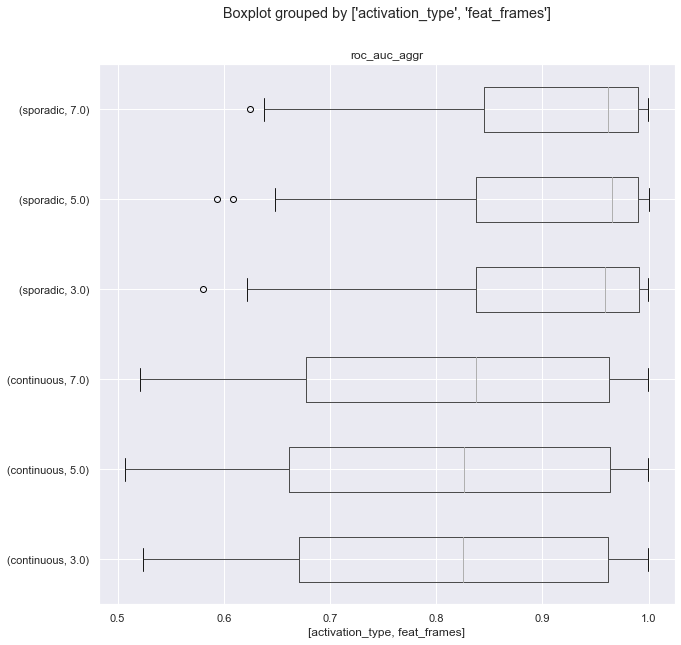

In [13]:
plt.figure(figsize=(10,10))
df[(df.feat_frames != np.nan)].boxplot(column='roc_auc_aggr', by=['activation_type', 'feat_frames'], figsize=(10,10), vert=False)
#sns.boxplot(data=df[~df.feat_frames.isna()], x='roc_auc_aggr', y='feat_frames')

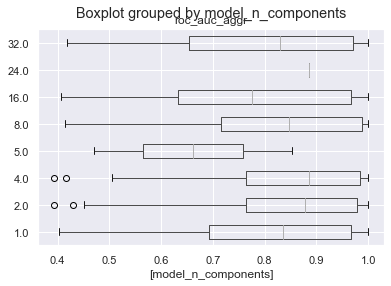

In [14]:
df.boxplot(column='roc_auc_aggr', by=['model_n_components'], vert=False)

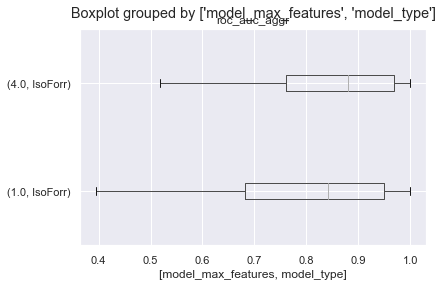

In [244]:
df.boxplot(column='roc_auc_aggr', by=['model_max_features', 'model_type'], vert=False)

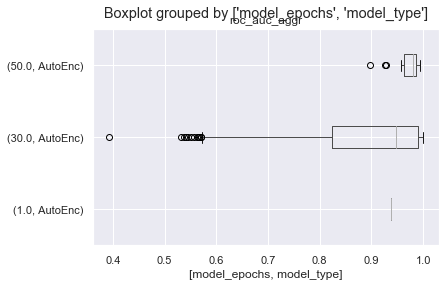

In [246]:
df.boxplot(column='roc_auc_aggr', by=['model_epochs', 'model_type'], vert=False)

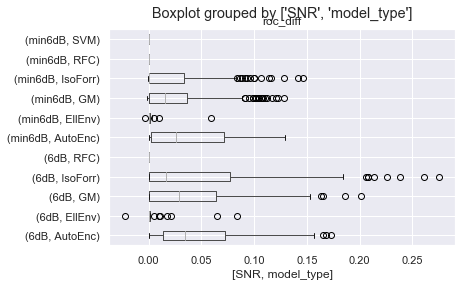

In [251]:
df.boxplot(column='roc_diff', by=['SNR', 'model_type'], vert=False)

In [ ]:
df.
